In [1]:
import openmc
import matplotlib.pyplot as plt

In [2]:
iter_sp = openmc.StatePoint("../reactors/iter_class/statepoint.100.h5")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../reactors/iter_class/statepoint.100.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
iter_tfcoil_spectrum = iter_sp.get_tally(id=4)

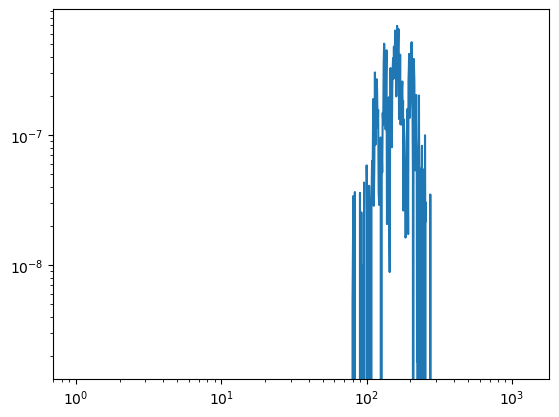

In [ ]:
plt.loglog(iter_tfcoil_spectrum.mean[:,0,0])

In [ ]:
openmc.Settings.weight_window_generators(mesh: openmc.MeshBase,
        energy_bounds: Optional[Sequence[float]] = None,
        particle_type: str = 'neutron',
        method: str = 'magic',
        max_realizations: int = 1,
        update_interval: int = 1,
        on_the_fly: bool = True)